In [1]:
import numpy as np

X = ['Tiger Left', 'Tiger Right']

A = ['Open Left', 'Open Right', 'Listen']

Z = ['Tiger Left', 'Tiger Right']

P_OL = np.ones([len(X), len(X)])/len(X) # uniform probability of tiger being behind any door
P_OR = P_OL
P_L = np.eye(len(X)) # when listening position of tiger doesn't change

O_OL = np.ones([len(X), len(X)])/len(X) # when door is opened world resets, back to tiger behind any door with uniform probability
O_OR = O_OL
O_L = np.array([[0.85, 0.15], [0.15, 0.85]]) # We can hear correct position of tiger with 0.85 probability

P = np.array([P_OL, P_OR, P_L])
O = np.array([O_OL, O_OR, O_L])

C = np.array([[1, 0, 0.1], [0, 1, 0.1]]) # Maximum cost if we pick wrong door, small cost for listening

In [2]:
def belief_update(b, P, O):
    b = np.matmul(b,P)*O.T
    
    return b/np.linalg.norm(b,1) 

In [3]:
b0 = np.array([0.5, 0.5]) # uniform initial belief

b1 = belief_update(b0, P[2], O[2][:,1]) # belief after listening to tiger on the right

print(b1)

b2 = belief_update(b1, P[2], O[2][:,1]) # belief after listening to tiger on the right again

print(b2)

b3 = belief_update(b2, P[2], O[2][:,0]) # belief after listening to tiger on the left

print(b3)

[0.15 0.85]
[0.03020134 0.96979866]
[0.15 0.85]


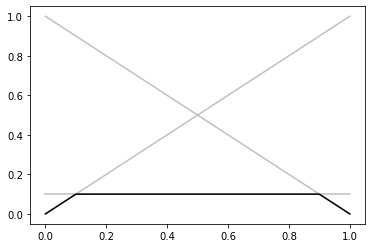

In [4]:
import matplotlib.pyplot as plt

grey = '#C0C0C0'

p = np.linspace(0,1,101)
p = np.reshape(p, [p.size, 1])

B = np.hstack((p, 1-p)) # discrete belief space

J = np.matmul(B, C)

plt.plot(p, J, grey)

J = np.min(J, axis = 1)

plt.plot(p, J, 'k')

In [5]:
gamma = 0.75

In [6]:
alpha_list = C

In [7]:
def value_iteration(alpha_list, P, O, C):
    
    # creating Gamma_a,z
    
    alpha_list = alpha_list.T.reshape([alpha_list.shape[1], alpha_list.shape[0], 1])
    alpha_list_new = np.zeros([len(A), len(Z), *alpha_list.shape])
    
    for a in range(P.shape[0]):
        for z in range(O.shape[2]):
            aux = 1/len(Z)*C[:,a].reshape([C.shape[0],1]) + gamma*(P[a]*O[a][:,z].T)@alpha_list
            alpha_list_new[a][z][:] = aux
                  
    alpha_list = np.array(alpha_list_new)
    
    # creating Gamma_a
    
    alpha_list_a = np.zeros([alpha_list.shape[0], alpha_list.shape[2]**alpha_list.shape[1], alpha_list.shape[3], 1])

    for a in range(len(A)):
        i = 0
        for vector in alpha_list[a][0]:
            aux = vector + alpha_list[a][1]
            for vector in aux:
                alpha_list_a[a][i] = vector
                i+=1
                
    alpha_list_a = alpha_list_a.reshape([alpha_list_a.shape[0], alpha_list_a.shape[1], alpha_list_a.shape[2]])
    
    # creating Gamma
    
    aux = alpha_list_a[0]
    
    for a in range(1, P.shape[0]):
        
        aux = np.array([x for x in set(tuple(x) for x in aux) | set(tuple(x) for x in alpha_list_a[a])])
        
    alpha_list = aux.T
    
    return alpha_list

In [8]:
alpha_list = value_iteration(alpha_list, P, O, C)

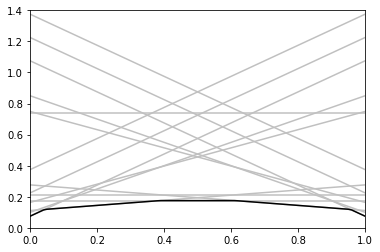

In [9]:
J = np.matmul(B, alpha_list)

plt.plot(p, J, grey)

J = np.min(J, axis = 1)

plt.xlim([0, 1])
plt.ylim([0,1.4])

plt.plot(p, J, 'k')

In [10]:
def prune(alpha_list, B):
    index = []

    for i in range(alpha_list.shape[1]):
        a = np.matmul(B, alpha_list[:,i].reshape([alpha_list.shape[0],1]))
        b = np.matmul(B, np.delete(alpha_list, i, axis = 1))

        if np.any(np.all(np.less(a, b), axis = 1)):
            index.append(i)
            
    alpha_list = np.take(alpha_list, index, axis = 1)
    
    return alpha_list

In [11]:
alpha_list = prune(alpha_list, B)

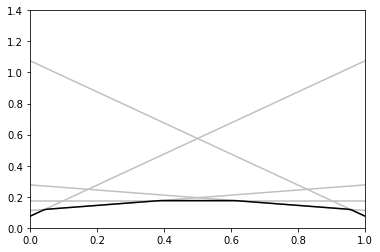

In [12]:
J = np.matmul(B, alpha_list)

plt.plot(p, J, grey)

J = np.min(J, axis = 1)

plt.xlim([0, 1])
plt.ylim([0,1.4])

plt.plot(p, J, 'k')

In [13]:
for i in range(21):
    alpha_list = value_iteration(alpha_list, P, O, C)
    alpha_list = prune(alpha_list, B)

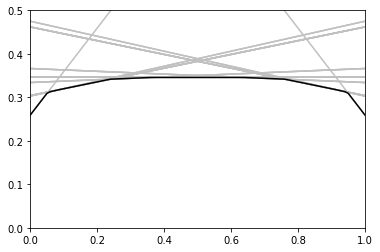

In [14]:
J = np.matmul(B, alpha_list)

plt.plot(p, J, grey)

J = np.min(J, axis = 1)

plt.xlim([0, 1])
plt.ylim([0,0.5])

plt.plot(p, J, 'k')

In [15]:
alpha_list.shape

(2, 27)